# Case Study - ENRON

In this notebook we highlight a particular dataset, namely the ENRON email dataset.
Our aim is to showcase the new observables created for annotated hypergraphs and to highlight the effect of the null model.

In [88]:
import pandas as pd
import numpy as np
import networkx as nx
# import matplotlib.pyplot as plt
# %matplotlib inline
import ternary
import seaborn as sns

from ahyper import AnnotatedHypergraph

import matplotlib.pyplot as plt

In [144]:
A = AnnotatedHypergraph.from_incidence('enron', 
                                       relabel_roles=True,
                                       add_metadata=True,
                                       root='../data/')
A.assign_role_interaction_matrix(np.array([[0,1,0.25],[0,0,0],[0,0,0]]))
G = A.to_weighted_projection(use_networkx=True)

## Features

### Graph

In [20]:
# TO DO: Create a snapshot of the network where nodes are pie charts of their roles.
import graph_tool

ModuleNotFoundError: No module named 'graph_tool'

### Node Role Density and Neighbourhood Role Density

In [3]:
# TODO: Ternary plot? Local density v null models, local density v node role participation
# TODO: Calculate distance between node role and local neighbourhood?

In [4]:
# !pip install python-ternary --user --quiet
# !pip install seaborn --user --quiet

In [5]:
from ahyper.observables import local_role_density, node_role_participation

In [145]:
local_role_den = pd.DataFrame(local_role_density(A)).T
node_role_par = pd.DataFrame(node_role_participation(A)).T

#### FIGURE 1A

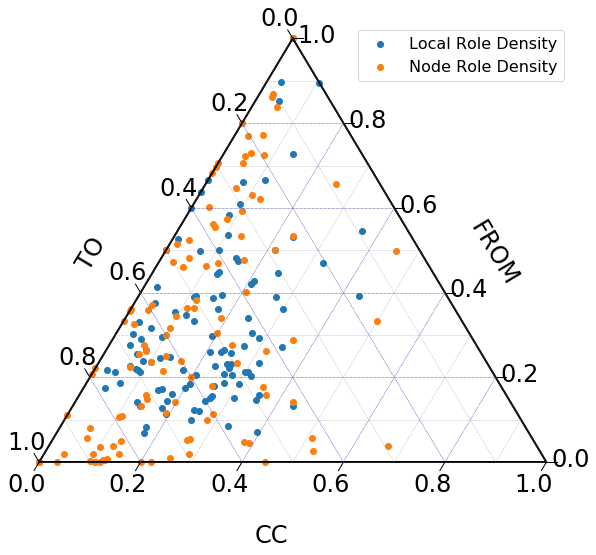

In [151]:
fig, tax = ternary.figure(scale=1)
fig.set_size_inches(10, 9)

tax.scatter(local_role_den.values, marker='o', color='C0', label="Local Role Density")
tax.scatter(node_role_par.values, marker='o', color='C1', label="Node Role Density")

tax.boundary(linewidth=2.0)
tax.gridlines(multiple=0.2, color="blue")

tax.ticks(ticks=[0,0.2,0.4,0.6,0.8,1], axis='lbr', linewidth=1, 
          tick_formats='%.1f', 
          fontsize=24,
          offset=0.02)
tax.left_axis_label("TO", offset=0.15, fontsize=24)
tax.right_axis_label("FROM", offset=0.15, fontsize=24)
tax.bottom_axis_label("CC", offset=0.15, fontsize=24)

fontsize = 16
offset = 0.15

tax.legend(fontsize=fontsize)
tax.boundary(linewidth=1)
tax.gridlines(multiple=0.1, color="gray")
tax.get_axes().axis('off')

tax.ax.axis('off');
tax._redraw_labels()

fig.savefig('../fig/roles_local_v_node.pdf', bbox_inches='tight')

In [147]:
lines = list(zip(local_role_den.index, local_role_den.values, node_role_par.values))

def size(line):
    index,x,y = line
    return ((x-y)**2).sum()

lines.sort(key=lambda x: size(x), reverse=True)

names = pd.read_csv('../data/enron/enron_jobs.csv', index_col='node_id')
# [names.loc[x] for x,_,_ in lines[:5]]
ids = names.query('job=="CEO"').index
focus = [l for l in lines if l[0] in ids]

def format_name(string):
    return ' '.join(string.split('.')).title()

name_annotations = [(f[0],f[2],format_name(names['name'][f[0]])) for f in focus]

#### FIGURE 1B

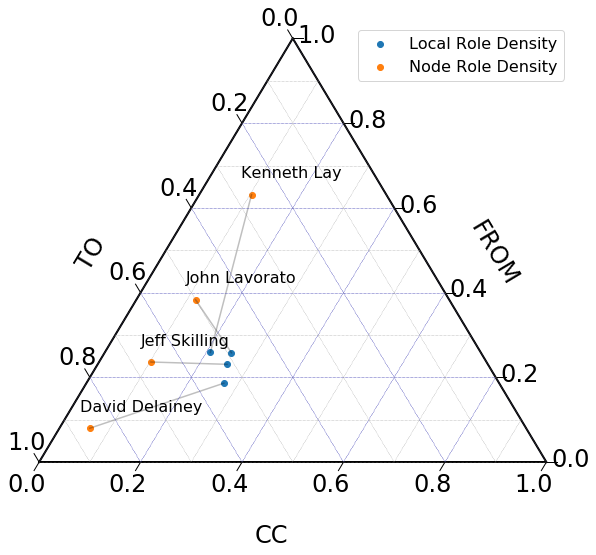

In [152]:
fig, tax = ternary.figure(scale=1)
fig.set_size_inches(10, 9)

fontsize = 16
offset = 0.15


first=True
for line in focus:
    
    tax.plot(line[1:], color='k', alpha=0.25)
    lr = tax.scatter([line[1]], marker='o', color='C0', label="Local Role Density")
    nr = tax.scatter([line[2]], marker='o', color='C1', label="Node Role Density")

    if first:
        tax.legend(fontsize=fontsize)
        first=False
        
for ix,point,name in name_annotations:
    tax.annotate(name, position=point + np.array([-0.04, 0.04, 0.00]), fontsize=fontsize)
        
tax.boundary(linewidth=2.0)
tax.gridlines(multiple=0.2, color="blue")

tax.ticks(ticks=[0,0.2,0.4,0.6,0.8,1], axis='lbr', linewidth=1, 
          tick_formats='%.1f', 
          fontsize=24,
          offset=0.02)
tax.left_axis_label("TO", offset=0.15, fontsize=24)
tax.right_axis_label("FROM", offset=0.15, fontsize=24)
tax.bottom_axis_label("CC", offset=0.15, fontsize=24)

tax.boundary(linewidth=1)
tax.gridlines(multiple=0.1, color="gray")
tax.get_axes().axis('off')

tax.ax.axis('off');
tax._redraw_labels()

fig.savefig('../fig/roles_assortativity.pdf', bbox_inches='tight')

In [149]:
A._degeneracy_avoiding_MCMC(n_steps=len(A.IL)*100, role_labels=True)
local_role_den_rp = pd.DataFrame(local_role_density(A)).T

A._degeneracy_avoiding_MCMC(n_steps=len(A.IL)*100, role_labels=False)
local_role_den_rd = pd.DataFrame(local_role_density(A)).T

#### Figure 1C

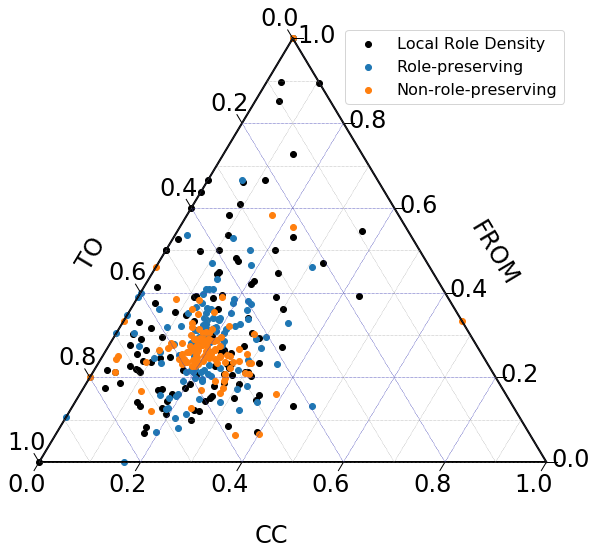

In [154]:
fig, tax = ternary.figure(scale=1)
fig.set_size_inches(10, 9)

tax.scatter(local_role_den.values, marker='o', color='black', label="Local Role Density")
tax.scatter(local_role_den_rp.values, marker='o', color='C0', label="Role-preserving")
tax.scatter(local_role_den_rd.values, marker='o', color='C1', label="Non-role-preserving")

tax.boundary(linewidth=2.0)
tax.gridlines(multiple=0.2, color="blue")

tax.ticks(ticks=[0,0.2,0.4,0.6,0.8,1], axis='lbr', linewidth=1, 
          tick_formats='%.1f', 
          fontsize=24,
          offset=0.02)
tax.left_axis_label("TO", offset=0.15, fontsize=24)
tax.right_axis_label("FROM", offset=0.15, fontsize=24)
tax.bottom_axis_label("CC", offset=0.15, fontsize=24)

fontsize = 16
offset = 0.15

tax.legend(fontsize=fontsize)
tax.boundary(linewidth=1)
tax.gridlines(multiple=0.1, color="gray")
tax.get_axes().axis('off')

tax.ax.axis('off');
tax._redraw_labels()

fig.savefig('../fig/roles_null_model.pdf', bbox_inches='tight')

### Role Assortativity

In [132]:
def read_results(path):
    """Read results from a directory."""
    
    original = pd.read_csv(f'{path}/original.csv', index_col=0, header=None)[1]
    role_preserving_ensemble = pd.read_csv(f'{path}/role_preserving_ensemble.csv', index_col=False, header=0)
    role_destroying_ensemble = pd.read_csv(f'{path}/role_destroying_ensemble.csv', index_col=False, header=0)

    return original, role_preserving_ensemble, role_destroying_ensemble

In [134]:
original, preserving_ensemble, destroying_ensemble = read_results('../results/enron_assort/')
results = read_results('../results/enron_assort')

In [135]:
assort_features = [f for f in original.index if 'assortativity' in f]

og = original[assort_features]
og = pd.DataFrame(og).T
pe = preserving_ensemble[assort_features]
de = destroying_ensemble[assort_features]

In [136]:
combined = pd.concat([og,pe,de],
                     keys=['Original','Role-preserving','Non-role-preserving'], 
                     names=['ensemble','sample'])

combined = combined.stack()
combined.index.names = ['ensemble','sample','feature']

In [137]:
combined = combined.reset_index()
combined.feature = combined.feature.apply(lambda x: '-'.join(x.split('_')[1:]))
combined[1] = ''

In [140]:
combined = combined.query('feature in ["from-to","from-cc","to-to","to-cc","cc-cc"]')

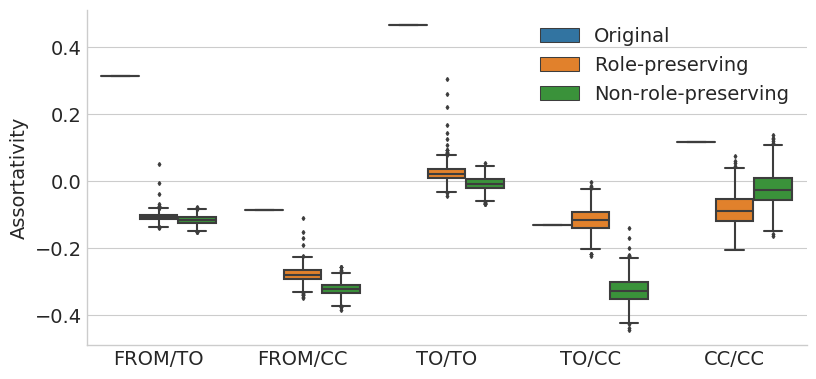

In [143]:
with plt.style.context("seaborn-whitegrid", {'font.size':14}):

    
    fontsize=14
    
    sns.catplot(data=combined,
                kind='box',
                hue='ensemble',
                x='feature',
                y=0,
                linewidth=1.5,
                fliersize=2,
                notch=False,
                height=4, 
                aspect=2,
                legend_out=False,
                )

    fig = plt.gcf()
    ax = plt.gca()

    # AXIS LABELS
#     ax.set_xlabel('Role Pair');
    ax.set_xlabel(None);
    ax.set_ylabel('Assortativity', fontsize=fontsize);

    # XTICKLABELS
    z = [x.get_text() for x in list(ax.get_xticklabels())]
    z = [x.replace('-','/').upper() for x in z]
    ax.set_xticklabels(z, fontsize=fontsize);
    ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize)

    # LEGEND
    ax.legend(fontsize=fontsize);

    fig.savefig('../fig/enron_assortativity.pdf', bbox_inches='tight')

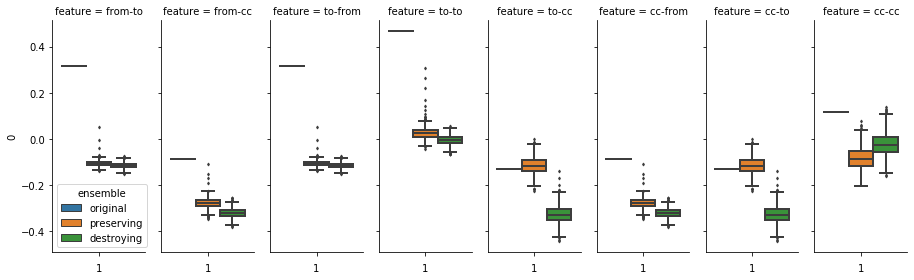

In [84]:
# Alternate formulation with individual axes.

sns.catplot(data=combined,
            kind='box',
            hue='ensemble',
            x=1,
            y=0,
            col='feature',
            linewidth=2,
            fliersize=2,
            notch=False,
            height=4, 
            aspect=0.4,
            legend_out=False,
            )